<a href="https://colab.research.google.com/github/knoppin1/DATA-690-WANG/blob/master/Individual_Project/covid_daily_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 Daily Report
### Ken Noppinger

Source from Gitbhub for Johns Hopkins Resource Center: 

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-17-2020.csv

In [1]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-17-2020.csv

--2020-10-18 22:22:20--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/10-17-2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 554635 (542K) [text/plain]
Saving to: ‘10-17-2020.csv.16’

10-17-2020.csv.16   100%[===================>] 541.64K  --.-KB/s    in 0.06s   

2020-10-18 22:22:20 (8.52 MB/s) - ‘10-17-2020.csv.16’ saved [554635/554635]



In [2]:
# Issue with pandas profiling
# Upgrade both packages solve the problem

!pip install  pandas pandas_profiling --upgrade

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.3)
Requirement already up-to-date: pandas_profiling in /usr/local/lib/python3.6/dist-packages (2.9.0)


In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

In [4]:
print("pandas version:\t", pd.__version__)

pandas version:	 1.1.3


## Read COVID-19 Daily Report

In [5]:
covid_df = pd.read_csv("10-17-2020.csv")
covid_df.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-10-18 04:24:25,33.93911,67.709953,40141,1488,33561,5092.0,Afghanistan,103.115106,3.706933
1,NaN,NaN,NaN,Albania,2020-10-18 04:24:25,41.15330,20.168300,16774,448,10001,6325.0,Albania,582.875808,2.670800
2,NaN,NaN,NaN,Algeria,2020-10-18 04:24:25,28.03390,1.659600,54203,1846,37971,14386.0,Algeria,123.607094,3.405716
3,NaN,NaN,NaN,Andorra,2020-10-18 04:24:25,42.50630,1.521800,3377,59,2057,1261.0,Andorra,4370.672361,1.747113
4,NaN,NaN,NaN,Angola,2020-10-18 04:24:25,-11.20270,17.873900,7462,241,3022,4199.0,Angola,22.704129,3.229697


In [6]:
covid_df.shape

(3957, 14)

### Cleanup Columns

In [7]:
covid_df.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')

Rename the following columns: Admin2 and Combined_Key

In [8]:
covid_df.rename(columns = {'Admin2':'County', 'Combined_Key':'Place'}, inplace = True)

Remove columns that irrelevant to the study

In [9]:
irrelevant_columns = ['Last_Update', 'Lat', 'Long_', 'Recovered', 'Active']
covid_df = covid_df.drop(irrelevant_columns, axis=1)
covid_df.head(3)

,FIPS,County,Province_State,Country_Region,Confirmed,Deaths,Place,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,40141,1488,Afghanistan,103.115106,3.706933
1,NaN,NaN,NaN,Albania,16774,448,Albania,582.875808,2.670800
2,NaN,NaN,NaN,Algeria,54203,1846,Algeria,123.607094,3.405716


Reorder columns

In [10]:
column_order = ['FIPS','County','Province_State','Country_Region','Place','Confirmed','Deaths','Incidence_Rate','Case-Fatality_Ratio'] 
covid_df = covid_df[column_order] 
covid_df.head(3) 

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,Afghanistan,40141,1488,103.115106,3.706933
1,NaN,NaN,NaN,Albania,Albania,16774,448,582.875808,2.670800
2,NaN,NaN,NaN,Algeria,Algeria,54203,1846,123.607094,3.405716


In [11]:
covid_df.shape

(3957, 9)

### Remove Irrelevant Data

Drop any duplicate rows.

In [12]:
covid_df = covid_df.drop_duplicates()
covid_df.shape

(3957, 9)

Determine how much of the dataframe is useful for the study.

In [13]:
covid_df["Country_Region"].value_counts().head(10)

US          3271
Russia        83
Japan         49
India         37
Colombia      34
China         33
Mexico        32
Brazil        27
Ukraine       27
Peru          26
Name: Country_Region, dtype: int64

Note: Non-US data is irrelvant since only US counties are being studied.

Only keep the records representing US data.

In [14]:
covid_us_df = covid_df[covid_df.Country_Region == "US"]
covid_us_df.shape

(3271, 9)

Check Data Types and Counts

In [15]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3957 entries, 0 to 3956
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3260 non-null   float64
 1   County               3265 non-null   object 
 2   Province_State       3788 non-null   object 
 3   Country_Region       3957 non-null   object 
 4   Place                3957 non-null   object 
 5   Confirmed            3957 non-null   int64  
 6   Deaths               3957 non-null   int64  
 7   Incidence_Rate       3876 non-null   float64
 8   Case-Fatality_Ratio  3914 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 309.1+ KB


The Non-Null counts are not the same, so cleanup missing data before moving forward.

### Missing Data Cleanup

Visualize the dataframe to identify missing data

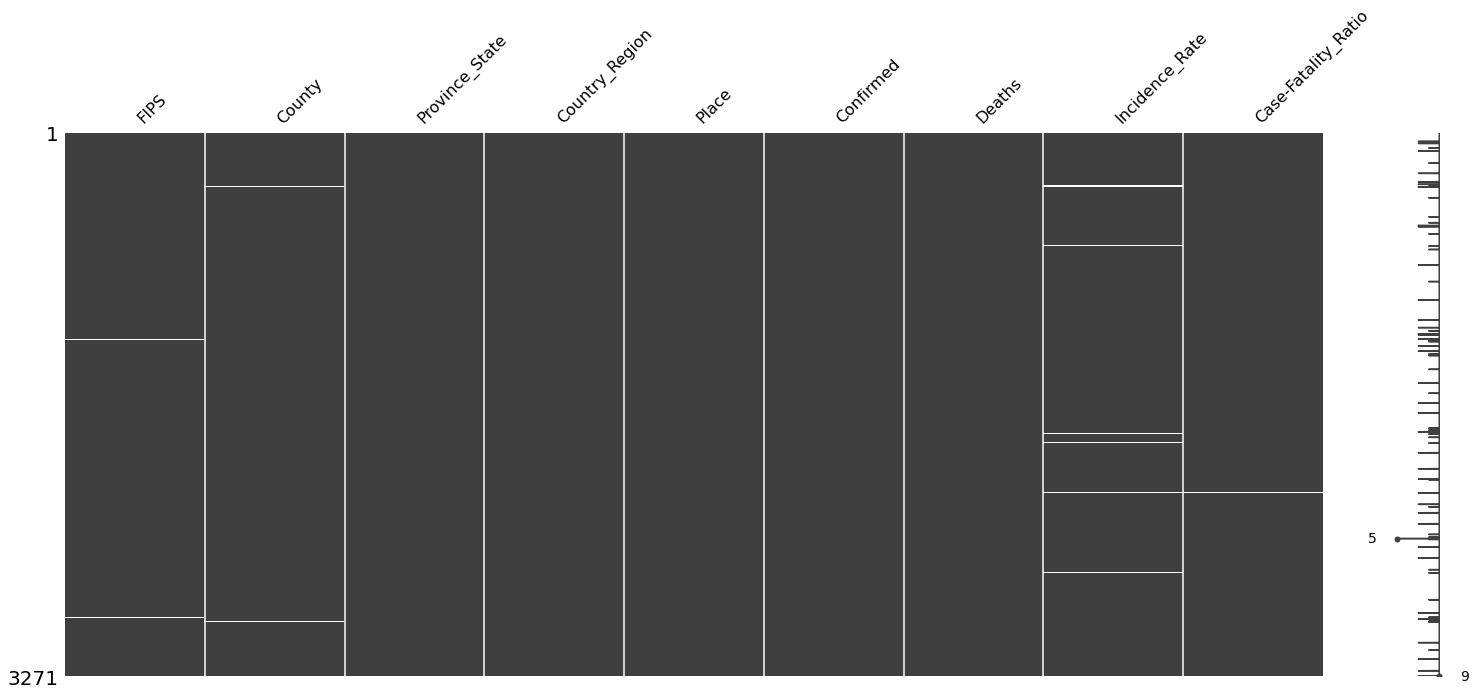

In [16]:
# Reference: https://analyticsindiamag.com/tutorial-on-missingno-python-tool-to-visualize-missing-values/
import missingno as msno
msno.matrix(covid_us_df)

Investigate records without a FIPS code

In [17]:
covid_nofips_us_df = covid_us_df[covid_us_df.FIPS.isna()]
covid_nofips_us_df.shape

(11, 9)

In [18]:
covid_nofips_us_df

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
1880,NaN,Dukes and Nantucket,Massachusetts,US,"Dukes and Nantucket, Massachusetts, US",204,2,710.034458,0.980392
1915,NaN,Federal Correctional Institution (FCI),Michigan,US,"Federal Correctional Institution (FCI), Michig...",195,5,NaN,2.564103
1947,NaN,Michigan Department of Corrections (MDOC),Michigan,US,"Michigan Department of Corrections (MDOC), Mic...",5846,75,NaN,1.282928
2200,NaN,Kansas City,Missouri,US,"Kansas City, Missouri, US",13499,162,2760.853515,1.200089
3074,NaN,NaN,Recovered,US,"Recovered, US",0,0,NaN,NaN
3547,NaN,Bear River,Utah,US,"Bear River, Utah, US",4436,14,2374.503527,0.315600
3548,NaN,Central Utah,Utah,US,"Central Utah, Utah, US",1038,6,1266.564170,0.578035
3552,NaN,Southeast Utah,Utah,US,"Southeast Utah, Utah, US",357,3,887.419523,0.840336
3553,NaN,Southwest Utah,Utah,US,"Southwest Utah, Utah, US",5252,45,2083.779688,0.856816
3556,NaN,TriCounty,Utah,US,"TriCounty, Utah, US",309,2,545.724277,0.647249


Records lacking a FIPS code cannot be used in the study because the field will be joined with land area data needed to determine population density for each county.

Remove the records without a FIPS code.

In [19]:
covid_us_df = covid_us_df[covid_us_df.FIPS.notna()]
covid_us_df.shape

(3260, 9)

Investigate records without a County

In [20]:
covid_no_county_us_df = covid_us_df[covid_us_df.County.isna()]
covid_no_county_us_df.shape

(5, 9)

In [21]:
covid_no_county_us_df

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
960,88888.0,NaN,Diamond Princess,US,"Diamond Princess, US",49,0,NaN,0.000000
1191,99999.0,NaN,Grand Princess,US,"Grand Princess, US",103,3,NaN,2.912621
1192,66.0,NaN,Guam,US,"Guam, US",3538,63,2154.308922,1.780667
2720,69.0,NaN,Northern Mariana Islands,US,"Northern Mariana Islands, US",86,2,155.955317,2.325581
3576,78.0,NaN,Virgin Islands,US,"Virgin Islands, US",1335,21,1244.546370,1.573034


These records represent provinces or special COVID groupings irrelevant to the study and can be removed.

In [22]:
covid_us_df = covid_us_df[covid_us_df.County.notna()]
covid_us_df.shape

(3255, 9)

In [23]:
covid_us_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255 entries, 633 to 3903
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3255 non-null   float64
 1   County               3255 non-null   object 
 2   Province_State       3255 non-null   object 
 3   Country_Region       3255 non-null   object 
 4   Place                3255 non-null   object 
 5   Confirmed            3255 non-null   int64  
 6   Deaths               3255 non-null   int64  
 7   Incidence_Rate       3193 non-null   float64
 8   Case-Fatality_Ratio  3220 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 254.3+ KB


There are still NaNs in the following filed not critical to the study: Lat, Long_, Active, Incidence_Rate, Case-Fatality_Ratio.

Set these NaNs to a value of zero.

In [24]:
covid_us_df = covid_us_df.fillna({'Lat':0, 'Long_':0, 'Active':0, 'Incidence_Rate':0, 'Case-Fatality_Ratio':0})
covid_us_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255 entries, 633 to 3903
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   FIPS                 3255 non-null   float64
 1   County               3255 non-null   object 
 2   Province_State       3255 non-null   object 
 3   Country_Region       3255 non-null   object 
 4   Place                3255 non-null   object 
 5   Confirmed            3255 non-null   int64  
 6   Deaths               3255 non-null   int64  
 7   Incidence_Rate       3255 non-null   float64
 8   Case-Fatality_Ratio  3255 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 254.3+ KB


All NaNs addressed.  Check column statistics to identify any other missing data

In [25]:
covid_us_df.describe(include='all')

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
count,3255.000000,3255,3255,3255,3255,3255.000000,3255.000000,3255.000000,3255.000000
unique,NaN,1910,52,1,3255,NaN,NaN,NaN,NaN
top,NaN,Unassigned,Texas,US,"Dallam, Texas, US",NaN,NaN,NaN,NaN
freq,NaN,51,255,3255,1,NaN,NaN,NaN,NaN
mean,32376.990476,NaN,NaN,NaN,NaN,2477.603379,67.235330,2282.013221,2.073816
std,17889.419665,NaN,NaN,NaN,NaN,9649.688318,329.042006,1581.940143,2.958482
min,1001.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
25%,19056.000000,NaN,NaN,NaN,NaN,179.000000,2.000000,1192.244787,0.666667
50%,30069.000000,NaN,NaN,NaN,NaN,520.000000,8.000000,1982.596658,1.515450
75%,47036.000000,NaN,NaN,NaN,NaN,1513.000000,31.000000,3060.658905,2.752712


Note "Unassigned" is the most frequent value in the "admin2" column, which represents a county.  

This field should not be unassigned and needs to be investigated.

In [26]:
unassigned_df = covid_us_df[covid_us_df.County == "Unassigned"] 
unassigned_df.shape

(51, 9)

In [27]:
unassigned_df.sample(10)

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
3066,72999.0,Unassigned,Puerto Rico,US,"Unassigned, Puerto Rico, US",847,761,0.0,89.846517
3281,90047.0,Unassigned,Tennessee,US,"Unassigned, Tennessee, US",3461,3,0.0,0.086680
2445,90033.0,Unassigned,New Hampshire,US,"Unassigned, New Hampshire, US",12,0,0.0,0.000000
954,90009.0,Unassigned,Connecticut,US,"Unassigned, Connecticut, US",125,0,0.0,0.000000
725,90002.0,Unassigned,Alaska,US,"Unassigned, Alaska, US",24,0,0.0,0.000000
2919,90041.0,Unassigned,Oregon,US,"Unassigned, Oregon, US",0,0,0.0,0.000000
3572,90050.0,Unassigned,Vermont,US,"Unassigned, Vermont, US",8,0,0.0,0.000000
1973,90026.0,Unassigned,Michigan,US,"Unassigned, Michigan, US",10,0,0.0,0.000000
1889,90025.0,Unassigned,Massachusetts,US,"Unassigned, Massachusetts, US",3316,5,0.0,0.150784
3745,90053.0,Unassigned,Washington,US,"Unassigned, Washington, US",348,4,0.0,1.149425


Records with county field value of "Unassigned" represent states.

The study is looking at county-level population denisty, so state records are irrelevant and can be removed.

Remove the records with the county "Unassigned".

In [28]:
covid_counties_df = covid_us_df[covid_us_df.County != "Unassigned"]
covid_counties_df.shape

(3204, 9)

### Verify Data Types

In [29]:
covid_counties_df.dtypes

FIPS                   float64
County                  object
Province_State          object
Country_Region          object
Place                   object
Confirmed                int64
Deaths                   int64
Incidence_Rate         float64
Case-Fatality_Ratio    float64
dtype: object

FIPS code was read in as float because there were NaNs and that is a float type.

FIPS should be integer, so recast the column from float64 to int

Reference: https://stackoverflow.com/questions/49728421/pandas-dataframe-settingwithcopywarning-a-value-is-trying-to-be-set-on-a-copy

In [30]:
covid_counties_df = covid_counties_df.assign(FIPS=lambda x: x['FIPS'].astype(int))

In [31]:
covid_counties_df.sample(5)

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
2899,41021,Gilliam,Oregon,US,"Gilliam, Oregon, US",11,0,575.313808,0.000000
1590,20099,Labette,Kansas,US,"Labette, Kansas, US",330,5,1682.128657,1.515152
3372,48161,Freestone,Texas,US,"Freestone, Texas, US",438,4,2221.433281,0.913242
2337,31029,Chase,Nebraska,US,"Chase, Nebraska, US",116,0,2956.167176,0.000000
1039,13019,Berrien,Georgia,US,"Berrien, Georgia, US",478,12,2464.298603,2.510460


Number of Provinces/States

In [32]:
covid_counties_df.Province_State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [33]:
num_provinces_states = len(covid_counties_df.Province_State.unique())
num_provinces_states

52

Note that Puerto Rico and Washington, DC are included in the study.

### Pandas Profile Report

In [34]:
type(covid_counties_df)

pandas.core.frame.DataFrame

In [35]:
prof = ProfileReport(covid_counties_df, minimal=True)
prof.to_file(output_file="covid19_daily_report.html")
prof

## Read Population Data

In [36]:
!wget https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.xls

--2020-10-18 22:22:32--  https://www.ers.usda.gov/webdocs/DataFiles/48747/PopulationEstimates.xls
Resolving www.ers.usda.gov (www.ers.usda.gov)... 13.72.9.120
Connecting to www.ers.usda.gov (www.ers.usda.gov)|13.72.9.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5619712 (5.4M) [application/vnd.ms-excel]
Saving to: ‘PopulationEstimates.xls.15’

PopulationEstimates 100%[===================>]   5.36M  7.28MB/s    in 0.7s    

2020-10-18 22:22:34 (7.28 MB/s) - ‘PopulationEstimates.xls.15’ saved [5619712/5619712]



In [37]:
pop_df = pd.read_excel("PopulationEstimates.xls")
pop_df.head()

,"Population estimates for the U.S., States, and counties, 2010-19 (see the second tab in this workbook for variable name descriptions)",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164
0,These data were posted to the ERS website (at ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FIPStxt,State,Area_Name,Rural-urban_Continuum Code_2003,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2003,Urban_Influence_Code_2013,Economic_typology_2015,CENSUS_2010_POP,ESTIMATES_BASE_2010,POP_ESTIMATE_2010,POP_ESTIMATE_2011,POP_ESTIMATE_2012,POP_ESTIMATE_2013,POP_ESTIMATE_2014,POP_ESTIMATE_2015,POP_ESTIMATE_2016,POP_ESTIMATE_2017,POP_ESTIMATE_2018,POP_ESTIMATE_2019,N_POP_CHG_2010,N_POP_CHG_2011,N_POP_CHG_2012,N_POP_CHG_2013,N_POP_CHG_2014,N_POP_CHG_2015,N_POP_CHG_2016,N_POP_CHG_2017,N_POP_CHG_2018,N_POP_CHG_2019,Births_2010,Births_2011,Births_2012,Births_2013,Births_2014,Births_2015,Births_2016,Births_2017,Births_2018,Births_2019,...,R_death_2016,R_death_2017,R_death_2018,R_death_2019,R_NATURAL_INC_2011,R_NATURAL_INC_2012,R_NATURAL_INC_2013,R_NATURAL_INC_2014,R_NATURAL_INC_2015,R_NATURAL_INC_2016,R_NATURAL_INC_2017,R_NATURAL_INC_2018,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2011,R_INTERNATIONAL_MIG_2012,R_INTERNATIONAL_MIG_2013,R_INTERNATIONAL_MIG_2014,R_INTERNATIONAL_MIG_2015,R_INTERNATIONAL_MIG_2016,R_INTERNATIONAL_MIG_2017,R_INTERNATIONAL_MIG_2018,R_INTERNATIONAL_MIG_2019,R_DOMESTIC_MIG_2011,R_DOMESTIC_MIG_2012,R_DOMESTIC_MIG_2013,R_DOMESTIC_MIG_2014,R_DOMESTIC_MIG_2015,R_DOMESTIC_MIG_2016,R_DOMESTIC_MIG_2017,R_DOMESTIC_MIG_2018,R_DOMESTIC_MIG_2019,R_NET_MIG_2011,R_NET_MIG_2012,R_NET_MIG_2013,R_NET_MIG_2014,R_NET_MIG_2015,R_NET_MIG_2016,R_NET_MIG_2017,R_NET_MIG_2018,R_NET_MIG_2019
2,00000,US,United States,NaN,NaN,NaN,NaN,NaN,308745538,308758105,309321666,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523,563561,2235208,2274116,2162725,2307293,2334155,2306148,2044228,1701962,1552022,987836,3973485,3936976,3940576,3963195,3992376,3962654,3901982,3824521,3791712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01000,AL,Alabama,NaN,NaN,NaN,NaN,NaN,4779736,4780125,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185,5312,13632,16519,14493,11718,10548,11178,10961,13195,15504,14226,59690,59067,57929,58903,59647,59389,58961,58271,57313,...,10.6444,10.9252,10.9945,11.006,2.26553,2.22598,1.4676,1.90056,1.60324,1.58071,1.18423,0.943643,0.70147,0.973446,1.21003,1.04627,0.761796,0.9449,1.18919,0.618401,0.692264,0.566242,-0.395013,-0.0237138,0.476276,-0.198307,-0.318543,-0.444016,0.471965,1.08152,1.9175,0.578434,1.18631,1.52255,0.563489,0.626357,0.745172,1.09037,1.77379,2.48374
4,0100

Reread the excel file skipping the first two lines.

In [38]:
columns_of_interest = ['FIPStxt','State','Area_Name','POP_ESTIMATE_2019']
pop_df = pd.read_excel("PopulationEstimates.xls", usecols=columns_of_interest, skiprows=2)
pop_df.head()

,FIPStxt,State,Area_Name,POP_ESTIMATE_2019
0,0,US,United States,328239523
1,1000,AL,Alabama,4903185
2,1001,AL,Autauga County,55869
3,1003,AL,Baldwin County,223234
4,1005,AL,Barbour County,24686


In [39]:
pop_df.shape

(3273, 4)

### Remove Irrelevant Data

In [40]:
print(pop_df["State"].value_counts())

TX    255
GA    160
VA    134
KY    121
MO    116
KS    106
IL    103
NC    101
IA    100
TN     96
NE     94
IN     93
OH     89
MN     88
MI     84
MS     83
PR     79
OK     78
AR     76
WI     73
FL     68
PA     68
AL     68
SD     67
LA     65
CO     65
NY     63
CA     59
MT     57
WV     56
ND     54
SC     47
ID     45
WA     40
OR     37
NM     34
AK     30
UT     30
MD     25
WY     24
NJ     22
NV     18
ME     17
AZ     16
MA     15
VT     15
NH     11
CT      9
RI      6
HI      6
DE      4
DC      2
US      1
Name: State, dtype: int64


Remove the US record

In [41]:
pop_df = pop_df[pop_df.State != "US"]
pop_df.shape

(3272, 4)

Drop any duplicate rows.


In [42]:
pop_df = pop_df.drop_duplicates()
pop_df.shape

(3272, 4)

### Missing Data Cleanup

Visualize the population dataframe to identify any missing data

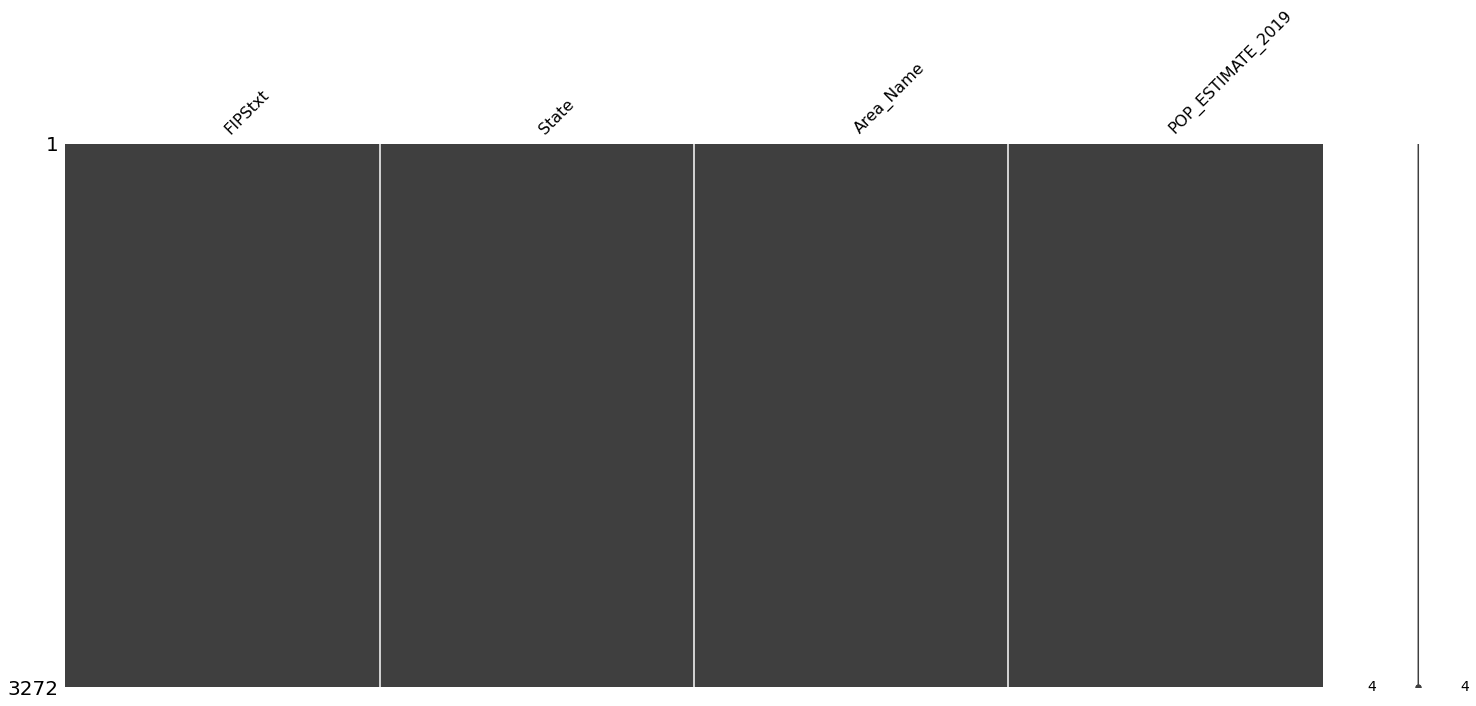

In [43]:
msno.matrix(pop_df)

### Verify Data Types

In [44]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3272 entries, 1 to 3272
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FIPStxt            3272 non-null   int64 
 1   State              3272 non-null   object
 2   Area_Name          3272 non-null   object
 3   POP_ESTIMATE_2019  3272 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 127.8+ KB


In [45]:
pop_df.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'], dtype=object)

In [46]:
num_states = len(pop_df.State.unique())
num_states

52

## Merge datasets

Compare FIPS codes before joining the dataframes to determine any anamoly.

In [47]:
# Unique FIPS codes in the Covid data for counties.
len(covid_counties_df.FIPS.unique())

3204

In [48]:
# Unique FIPS codes in the population data for counties.
len(pop_df.FIPStxt.unique())

3272

Inspect the different codes to determine if rows can be removed.

In [49]:
# FIPS codes in the Covid data but not in the population data.
no_pop_df = covid_counties_df[~covid_counties_df.FIPS.isin(pop_df.FIPStxt.values)]
no_pop_df

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
685,80001,Out of AL,Alabama,US,"Out of AL, Alabama, US",0,0,0.0,0.000000
928,80008,Out of CO,Colorado,US,"Out of CO, Colorado, US",0,0,0.0,0.000000
1139,80013,Out of GA,Georgia,US,"Out of GA, Georgia, US",14609,178,0.0,1.218427
1197,80015,Out of HI,Hawaii,US,"Out of HI, Hawaii, US",42,1,0.0,2.380952
1315,80017,Out of IL,Illinois,US,"Out of IL, Illinois, US",1,0,0.0,0.000000
1805,80022,Out of LA,Louisiana,US,"Out of LA, Louisiana, US",0,0,0.0,0.000000
1842,80023,Out of ME,Maine,US,"Out of ME, Maine, US",0,0,0.0,0.000000
1963,80026,Out of MI,Michigan,US,"Out of MI, Michigan, US",254,2,0.0,0.787402
2868,80040,Out of OK,Oklahoma,US,"Out of OK, Oklahoma, US",0,0,0.0,0.000000
3049,72888,Out of PR,Puerto Rico,US,"Out of PR, Puerto Rico, US",804,0,0.0,0.000000


These records represent non-county level Covid data and can be dropped.

In [50]:
# FIPS codes in the population data but not in the Covid data.
no_covid_df = pop_df[~pop_df.FIPStxt.isin(covid_counties_df.FIPS.values)]
no_covid_df

,FIPStxt,State,Area_Name,POP_ESTIMATE_2019
1,1000,AL,Alabama,4903185
69,2000,AK,Alaska,731545
79,2105,AK,Hoonah-Angoon Census Area,2148
85,2164,AK,Lake and Peninsula Borough,1592
99,4000,AZ,Arizona,7278717
...,...,...,...,...
3001,53000,WA,Washington,7614893
3041,54000,WV,West Virginia,1792147
3097,55000,WI,Wisconsin,5822434
3170,56000,WY,Wyoming,578759


These records represent non-county level population data and can be dropped.

Perform inner join to combine the two datafrmes eliminating both extraneous sets of data above.

In [51]:
county_df = covid_counties_df.merge(pop_df, how="inner", left_on='FIPS', right_on='FIPStxt').drop(['FIPStxt', 'Area_Name'], axis=1)
county_df

,FIPS,County,Province_State,Country_Region,Place,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio,State,POP_ESTIMATE_2019
0,1001,Autauga,Alabama,US,"Autauga, Alabama, US",1983,28,3549.374429,1.412002,AL,55869
1,1003,Baldwin,Alabama,US,"Baldwin, Alabama, US",6350,67,2844.548769,1.055118,AL,223234
2,1005,Barbour,Alabama,US,"Barbour, Alabama, US",977,9,3957.708823,0.921187,AL,24686
3,1007,Bibb,Alabama,US,"Bibb, Alabama, US",775,13,3460.748415,1.677419,AL,22394
4,1009,Blount,Alabama,US,"Blount, Alabama, US",1807,23,3124.891917,1.272828,AL,57826
...,...,...,...,...,...,...,...,...,...,...,...
3188,56037,Sweetwater,Wyoming,US,"Sweetwater, Wyoming, US",411,2,970.644499,0.486618,WY,42343
3189,56039,Teton,Wyoming,US,"Teton, Wyoming, US",692,1,2949.198773,0.144509,WY,23464
3190,56041,Uinta,Wyoming,US,"Uinta, Wyoming, US",401,2,1982.596658,0.498753,WY,20226
3191,56043,Washakie,Wyoming,US,"Washakie, Wyoming, US",133,7,1704.035874,5.263158,WY,7805


Rename and Reorder Columns


In [52]:
county_df.rename(columns = {'Country_Region':'Country', 'POP_ESTIMATE_2019':'Population_2019'}, inplace = True)
column_order = ['FIPS','County','Province_State','State','Country','Place','Population_2019','Confirmed','Deaths','Incidence_Rate','Case-Fatality_Ratio'] 
county_df = county_df[column_order] 
county_df.head(3) 

,FIPS,County,Province_State,State,Country,Place,Population_2019,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
0,1001,Autauga,Alabama,AL,US,"Autauga, Alabama, US",55869,1983,28,3549.374429,1.412002
1,1003,Baldwin,Alabama,AL,US,"Baldwin, Alabama, US",223234,6350,67,2844.548769,1.055118
2,1005,Barbour,Alabama,AL,US,"Barbour, Alabama, US",24686,977,9,3957.708823,0.921187


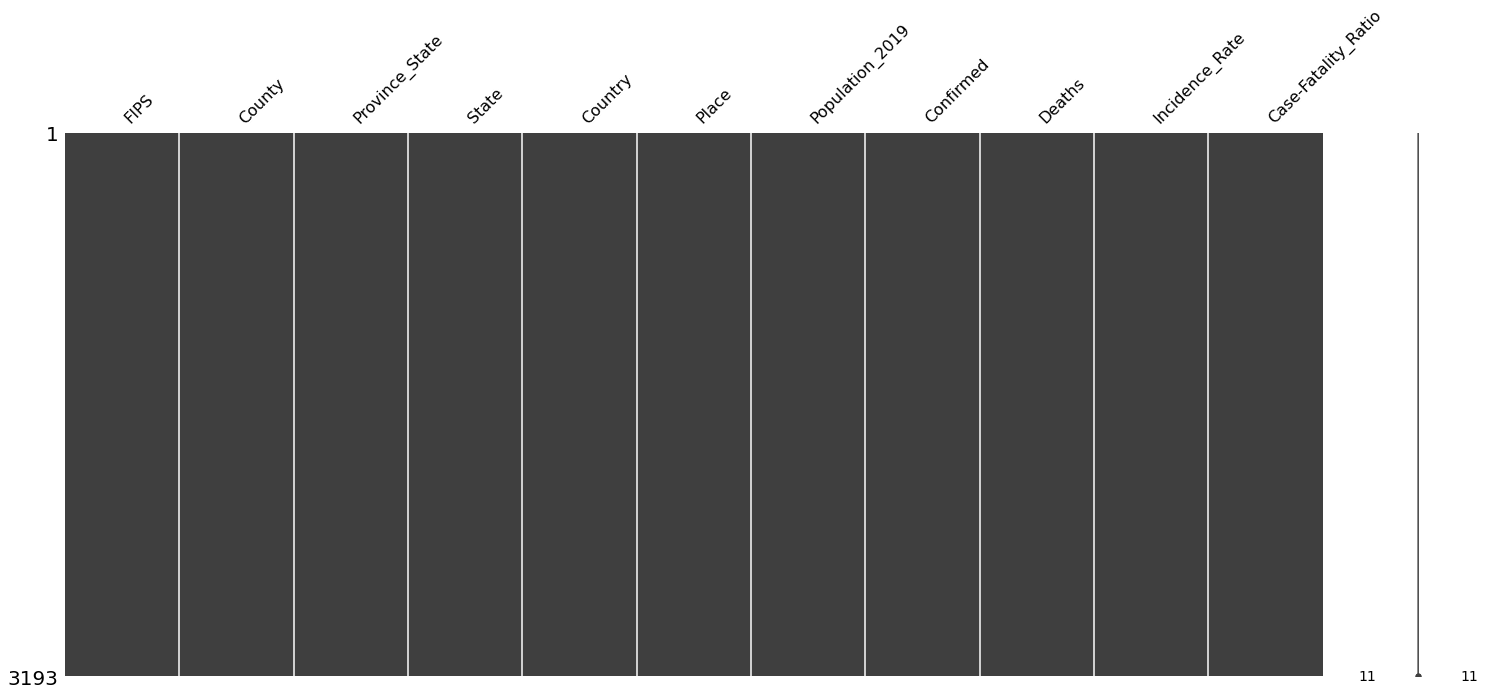

In [53]:
msno.matrix(county_df)

In [54]:
prof = ProfileReport(county_df, minimal=True)
prof.to_file(output_file="counties.html")
prof

Sample the county data.

In [55]:
county_df.sample(10)

,FIPS,County,Province_State,State,Country,Place,Population_2019,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
555,16015,Boise,Idaho,ID,US,"Boise, Idaho, US",7831,75,2,957.732090,2.666667
1419,28047,Harrison,Mississippi,MS,US,"Harrison, Mississippi, US",208080,4784,81,2299.115725,1.693144
1403,28015,Carroll,Mississippi,MS,US,"Carroll, Mississippi, US",9947,458,12,4604.403338,2.620087
62,1125,Tuscaloosa,Alabama,AL,US,"Tuscaloosa, Alabama, US",209355,9782,132,4672.446323,1.349417
501,13237,Putnam,Georgia,GA,US,"Putnam, Georgia, US",22119,765,27,3458.565035,3.529412
1632,30079,Prairie,Montana,MT,US,"Prairie, Montana, US",1077,29,0,2692.664810,0.000000
678,17163,St. Clair,Illinois,IL,US,"St. Clair, Illinois, US",259686,7460,211,2872.700107,2.828418
2692,48193,Hamilton,Texas,TX,US,"Hamilton, Texas, US",8461,182,4,2151.045976,2.197802
1500,29045,Clark,Missouri,MO,US,"Clark, Missouri, US",6797,99,0,1456.524937,0.000000
1679,31061,Franklin,Nebraska,NE,US,"Franklin, Nebraska, US",2979,70,0,2349.781806,0.000000


Sort the county data by population

In [56]:
county_df = county_df.sort_values(by='Population_2019', ascending=False)
county_df.head(10)

,FIPS,County,Province_State,State,Country,Place,Population_2019,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
202,6037,Los Angeles,California,CA,US,"Los Angeles, California, US",10039107,288136,6863,2870.135760,2.381861
607,17031,Cook,Illinois,IL,US,"Cook, Illinois, US",5150233,162220,5350,3149.760409,3.297990
2696,48201,Harris,Texas,TX,US,"Harris, Texas, US",4713325,153955,2726,3266.377769,1.770647
101,4013,Maricopa,Arizona,AZ,US,"Maricopa, Arizona, US",4485414,149202,3512,3326.381913,2.353856
220,6073,San Diego,California,CA,US,"San Diego, California, US",3338330,51982,869,1557.125868,1.671733
213,6059,Orange,California,CA,US,"Orange, California, US",3175692,56672,1409,1784.555933,2.486237
360,12086,Miami-Dade,Florida,FL,US,"Miami-Dade, Florida, US",2716940,177893,3537,6547.549817,1.988274
2652,48113,Dallas,Texas,TX,US,"Dallas, Texas, US",2635516,89433,1190,3393.377236,1.330605
1846,36047,Kings,New York,NY,US,"Kings, New York, US",2559903,72894,7366,2847.529770,10.105084
216,6065,Riverside,California,CA,US,"Riverside, California, US",2470546,63284,1269,2561.539028,2.005246


New York is known to have had the worst outbreak early on, so take a look at its most populated counties.

In [57]:
ny_top10_df = county_df[county_df.State=='NY'].head(10)
ny_top10_df

,FIPS,County,Province_State,State,Country,Place,Population_2019,Confirmed,Deaths,Incidence_Rate,Case-Fatality_Ratio
1846,36047,Kings,New York,NY,US,"Kings, New York, US",2559903,72894,7366,2847.529770,10.105084
1863,36081,Queens,New York,NY,US,"Queens, New York, US",2253858,74998,7285,3327.538825,9.713592
1853,36061,New York,New York,NY,US,"New York, New York, US",1628706,34871,3188,2141.024838,9.142267
1874,36103,Suffolk,New York,NY,US,"Suffolk, New York, US",1476601,47941,2016,3246.713229,4.205169
1825,36005,Bronx,New York,NY,US,"Bronx, New York, US",1418207,54307,4975,3829.271749,9.160882
1852,36059,Nassau,New York,NY,US,"Nassau, New York, US",1356924,48494,2204,3573.818431,4.544892
1882,36119,Westchester,New York,NY,US,"Westchester, New York, US",967506,39398,1460,4072.119449,3.705772
1837,36029,Erie,New York,NY,US,"Erie, New York, US",918702,12393,708,1348.968436,5.712902
1850,36055,Monroe,New York,NY,US,"Monroe, New York, US",741770,6671,300,899.335373,4.497077
1865,36085,Richmond,New York,NY,US,"Richmond, New York, US",476143,16670,1089,3501.049055,6.532693


### Function: scatter_plot_with_labels

In [96]:
def scatter_plot_with_labels(x_list, y_list, annotaton_labels, x_label, y_label, suptitle, title):

    assert len(x_list) == len(y_list) == len(annotation_labels) # verify all lists are of eaual length

    plt.figure(figsize=(14, 8))  # in inches
    plt.xlabel('\n'+ x_label, fontsize=16)
    plt.ylabel(y_label + '\n', fontsize=16)
    plt.suptitle(suptitle, fontsize=20, va='bottom')
    plt.title(title  + '\n', fontsize=18, va='center')
    plt.ticklabel_format(style='plain')
    
    for i, label in enumerate(annotation_labels): # get (0, label)
        x = x_list[i]
        y = y_list[i] 
        plt.scatter(x, y)         
        plt.annotate(label,
                     xy=(x, y), # show point 
                     xytext=(0, 4), # show annotate
                     textcoords='offset points',
                     ha='center',
                     va='bottom',
                     fontsize=10)

    plt.show()

### Show a scatter plot of confirmed cases for the top 10 most populated NY counties 

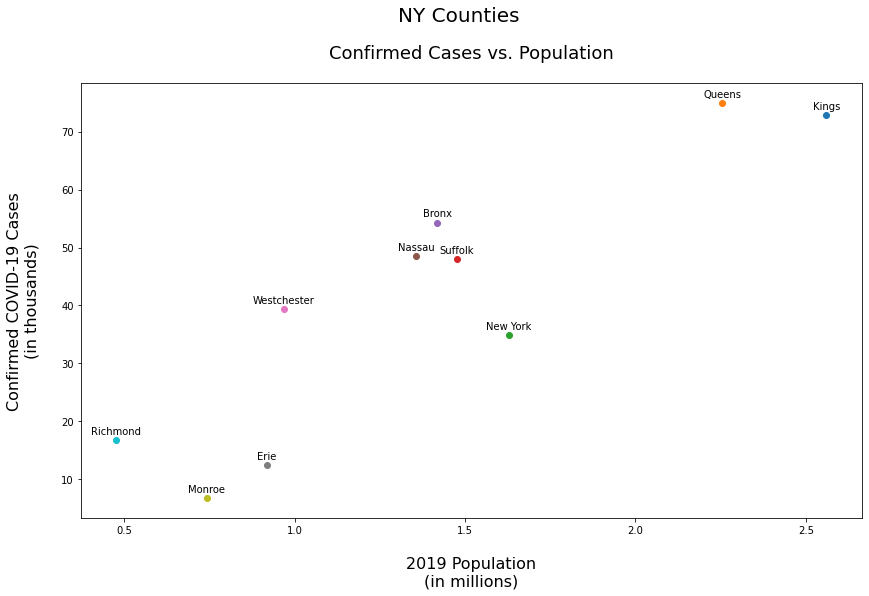

In [104]:
# Set titles
suptitle = 'NY Counties'
title = 'Confirmed Cases vs. Population'

# Set list of Populations in millions
x_list = [x / 1000000 for x in list(ny_top10_df.Population_2019)]
x_label = '2019 Population' + '\n' + '(in millions)'

# Set list of Confirmed Cases in thousands
# y_list = list(ny_top10_df.Confirmed)
y_list = [y / 1000 for y in list(ny_top10_df.Confirmed)]
y_label = 'Confirmed COVID-19 Cases' + '\n' + '(in thousands)'

# Set annotations
annotation_labels = ny_top10_df.County

# Show the scatter plot
scatter_plot_with_labels(x_list, y_list, annotation_labels, x_label, y_label, suptitle, title)

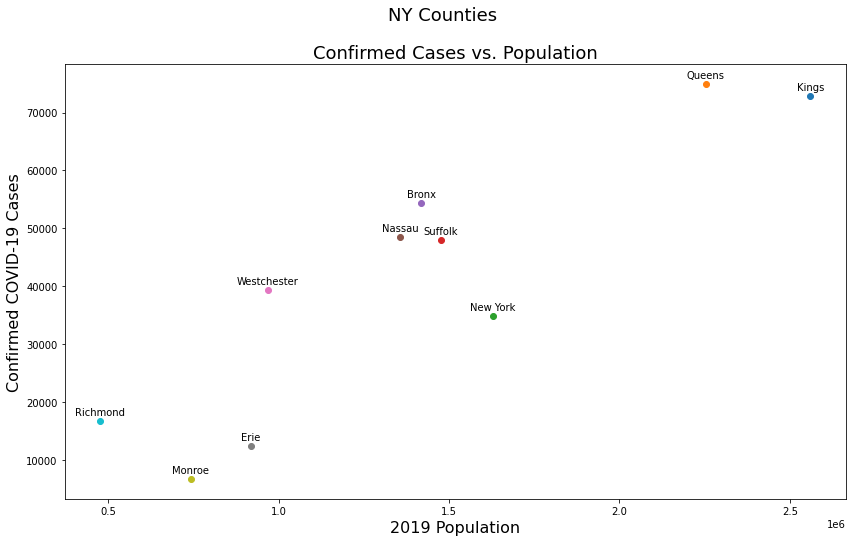

In [ ]:
# Create plot
fig = plt.figure(figsize=(14,6))
#ax = plt.gca()
plt.scatter(ny_top10_df.Population_2019, ny_top10_df.Confirmed, alpha=1.0, c="blue", edgecolors='none')
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.xlabel('2019 Population',fontsize=16)
plt.ylabel('Confirmed COVID-19 Cases',fontsize=16)
plt.suptitle('NY Counties',fontsize=20)
plt.title('Confirmed Cases vs. Population',fontsize=18)
plt.show()

---
## Read Land Area Data

In [ ]:
!wget https://www2.census.gov/library/publications/2011/compendia/usa-counties/excel/LND01.xls

In [ ]:
# STCOU - FIPS code for state or county
# Areaname - County and State
# LND110210D - Land area in square miles, 2010 SQM
columns_of_interest = ['Areaname','STCOU','LND110210D']
land_area_df = pd.read_excel("LND01.xls", usecols=columns_of_interest, skiprows=0)
land_area_df.head()

In [ ]:
land_area_df[land_area_df.Areaname == 'Howard, MD']

In [ ]:
land_area_df.shape

---
## Merge with county data

In [ ]:
county_df = county_df.merge(land_area_df, how="inner", left_on='FIPS', right_on='STCOU').drop(['STCOU', 'Areaname'], axis=1)
county_df

In [ ]:
county_df.rename(columns = {'POP_ESTIMATE_2019':'Population_2019', 'LND110210D':'Land_Area','Combined_Key':'Place'}, inplace = True)

In [ ]:
def ratio(x, y):
    return int(x / y)

In [ ]:
# pop_square_mile test
ratio(10039107, 4057.88)

In [ ]:
# pop_square_mile test
ratio(169, 668.93) 

In [ ]:
county_df["Pop_Sq_Mile"] = county_df[["Population_2019", "Land_Area"]].apply(lambda x: ratio(*x), axis=1)
county_df["Confirmed_Sq_Mile"] = county_df[["Confirmed", "Land_Area"]].apply(lambda x: ratio(*x), axis=1)
county_df["Deaths_Sq_Mile"] = county_df[["Deaths", "Land_Area"]].apply(lambda x: ratio(*x), axis=1)
county_df.head(10)

# Reorder columns


In [ ]:
column_order = ['FIPS','County','Province_State','State','Place','Population_2019','Land_Area','Pop_Sq_Mile', 'Confirmed','Confirmed_Sq_Mile','Deaths','Deaths_Sq_Mile','Incidence_Rate','Case-Fatality_Ratio'] 
county_df = county_df[column_order] 
county_df.head() 

In [ ]:
most_densely_populated_df = county_df.sort_values(by='Pop_Sq_Mile',ascending=False).head(15) 
most_densely_populated_df

In [ ]:
highest_case_rate_by_density_df = county_df.sort_values(by='Confirmed_Sq_Mile',ascending=False).head(15)
highest_case_rate_by_density_df

In [ ]:
# Create plot
fig = plt.figure(figsize=(14,6))
#ax = plt.gca()
plt.scatter(county_df.Pop_Sq_Mile, county_df.Confirmed_Sq_Mile , alpha=0.3, c="blue", edgecolors='none')
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.xlabel('Population Per Square Mile',fontsize=16)
plt.ylabel('Confirmed COVID-19 Cases Per Square Mile',fontsize=16)
plt.title('Confirmed Cases Per Square Mile vs. Population Per Square Mile',fontsize=18)
plt.suptitle('US Counties',fontsize=20)
#plt.legend(loc=2)#
plt.show()

In [ ]:

county_df.hist(figsize=(14,10))

In [ ]:
county_df['Land_Area'].hist()